# Complete age groups detailed model - Analysis

- 11 age groups from TABNET
- high season with tranamission, low season with no transmission, deterministic
- Plotting the infected over time and the age pattern of infection
- We will analyse the progression of the age pattern and the proportion of recovered in each age group as beta changes, maybe to see if there exist the possibility of a transition
- And also what happens in a city with low transmission which then experiences a 'climate' change

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
np.random.seed(123)

In [14]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [15]:
@np.vectorize
def beta_cos(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  return beta_0*np.cos(2*np.pi*t/365)+beta_aug

In [16]:
def modify_initial_condition(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # suscteptible reduction
    y_tmp[N:2*N] = (y_aux[N:2*N]*pop + 1)/pop # infected grow
    y_tmp[3*N:4*N] = (y_aux[3*N:4*N]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [17]:
def modify_initial_condition_2(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[4] = (y_aux[4]*pop - 1)/pop # suscteptible reduction
    y_tmp[N+4] = (y_aux[N+4]*pop + 1)/pop # infected grow
    y_tmp[3*N+4] = (y_aux[3*N+4]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [18]:
def n_groups_seasonal_model(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    C = y[3*N:4*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    C = np.append(C,0)
    C = np.append(0,C)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2]
    dIdt =  beta*S[1:-1]*IT - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    dSdt[0] = dSdt[0] + nu
    dCdt = beta*S[1:-1]*IT
    return np.array([dSdt, dIdt, dRdt,dCdt]).flatten()

In [19]:
def calculate_l_vector(alpha,l1):
    list_l = [] # creando uma lista l l1, l2, l3, .....
    elements_l = alpha.shape[0]
    for i in range(elements_l):
        # if it is the first element
        if(i == 0):
            list_l.append(l1)
        elif(i == elements_l-1): # if it is the last element (mortality term)
            list_l.append(list_l[-1]*alpha[-2]/alpha[-1])
        else: # in other case (intermediate elements)
            list_l.append(list_l[-1]*alpha[i-1]/alpha[i])
    return list_l

In [20]:
# number of age groups
N = 11

# number of people per age group
alpha1 = 793061 # 0 to 4 
alpha2 = 803773 # 5 to 9
alpha3 = 836496 # 10 to 14
alpha4 = 877970 # 15 to 19
alpha5 = 1960304 # 20 to 29
alpha6 = 1995084 # 30 to 39
alpha7 = 1666076 # 40 to 49
alpha8 = 1319655 # 50 to 59
alpha9 = 878162 # 60 to 59
alpha10 = 476538 # 70 to 79 
alpha11 = 245667 # 80+

# creating vector of alphas
alpha_pop = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])

# total population 
pop = alpha_pop.sum()

# dividing by total population
alpha1 = alpha1/pop
alpha2 = alpha2/pop
alpha3 = alpha3/pop
alpha4 = alpha4/pop
alpha5 = alpha5/pop
alpha6 = alpha6/pop
alpha7 = alpha7/pop
alpha8 = alpha8/pop
alpha9 = alpha9/pop
alpha10 = alpha10/pop
alpha11 = alpha11/pop

# creating a new vector of alphas (divided by overall population, as proportions)
alpha = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])


# demographical constants for the model
l1 = 1/(365*5) # how long does the first age group last (in days)?
nu = l1*alpha[0] # calculating the corresponding birth rate
l_vec = calculate_l_vector(alpha, l1) # calculating l aging elements + coupled death rate
mu_vec = np.array([0,0,0,0,0,0,0,0,0,0, l_vec[-1]]) # death rates array
# calculating aging rates vector
l_vec = l_vec[:-1] 
l_vec.append(0)
l_vec = np.array(l_vec)

In [21]:
# constructs initial condition with one infected adult in the 20-29 age range
def define_initial_condition():
    y0 = np.array([alpha1,alpha2,alpha3,alpha4,(alpha5*pop-1)/pop,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0])
    return y0

## Part 1: Dependence of age pattern on $\beta$ - Age pattern itself

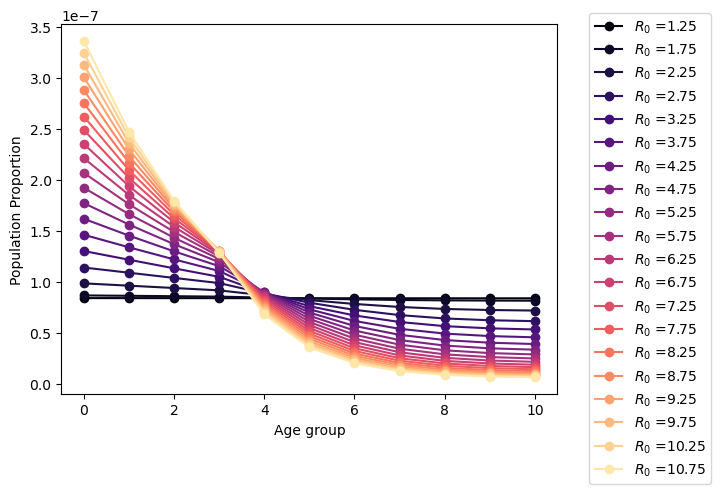

In [117]:
# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 100
i = 0

# colormap
cmap = 'magma'

for beta_aug in np.arange(1.25,11.25,0.25):
    y0 = define_initial_condition()
    beta_aug = beta_aug*gamma
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        if(season == seasons-1):
            inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
            prop_pop = alpha*pop*inf_total
            if(i%2 == 0):
                plt.plot((pop/prop_pop)*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 0), '-o', label = r'$R_0$ =' + str(round(beta_aug/gamma,2)), color = sns.color_palette(cmap, 40)[i])
    i = i + 1
plt.ylabel('Population Proportion')
plt.xlabel('Age group')
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

## Part 2: Dependence of age pattern on $\beta$ - Recovered/Susceptibility numbers

In [112]:
# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 100

# final result list
res_fin = []

for beta_aug in np.arange(1.25,11.25,0.25):
    y0 = define_initial_condition()
    beta_aug = beta_aug*gamma
    res_tmp = []
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        prop_pop = alpha*pop*inf_total
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
        if(season == seasons - 1):
            res_tmp.append(list(100*ret[-1,2*N:3*N]/alpha))
    #plt.legend()
    plt.show()
    res_fin.append(res_tmp)

In [113]:
res_fin = np.array(res_fin).reshape(40,11)

In [114]:
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']

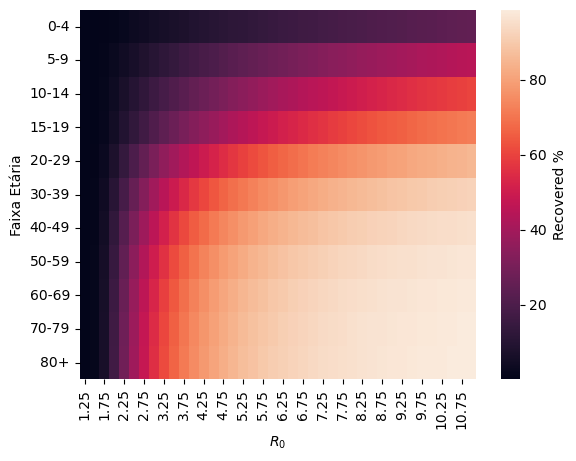

In [115]:
ax = sns.heatmap(res_fin.T)
ax.collections[0].colorbar.set_label("Recovered %")
ax.set(xticklabels = np.arange(1.25,11.25,0.5),
       yticklabels = faixas_etarias,
      xlabel=r'$R_0$',
      ylabel="Faixa Etária")
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.show()

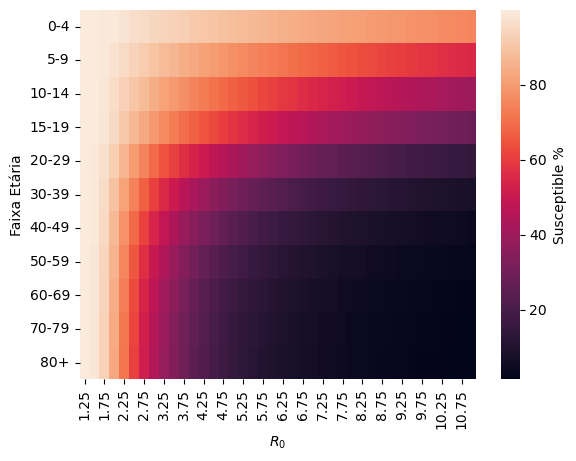

In [116]:
res_fin_2 = 100 - res_fin 
ax = sns.heatmap(res_fin_2.T)
ax.collections[0].colorbar.set_label("Susceptible %")
ax.set(xticklabels = np.arange(1.25,11.25,0.5),
       yticklabels = faixas_etarias,
      xlabel=r'$R_0$',
      ylabel="Faixa Etária")
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.show()

## Part 3: Dependence of endemic incidence on $\beta$

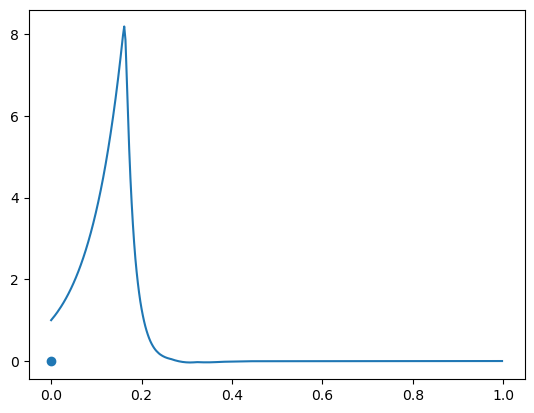

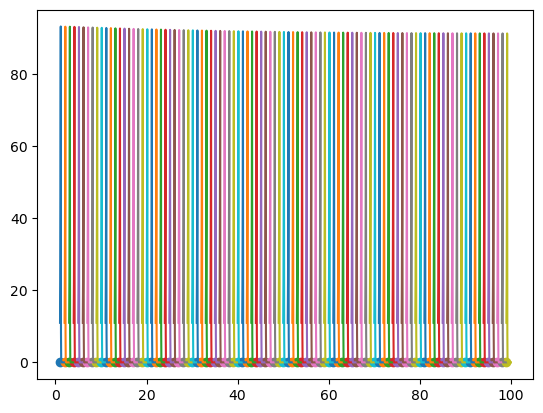

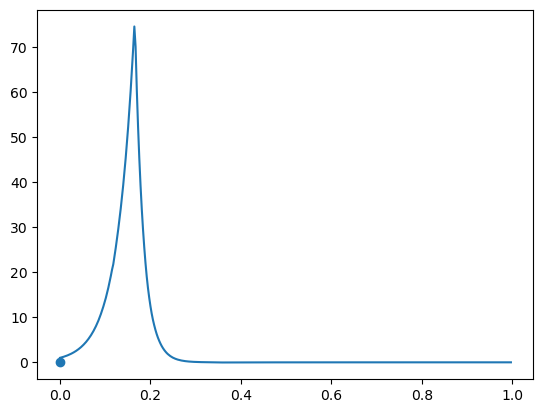

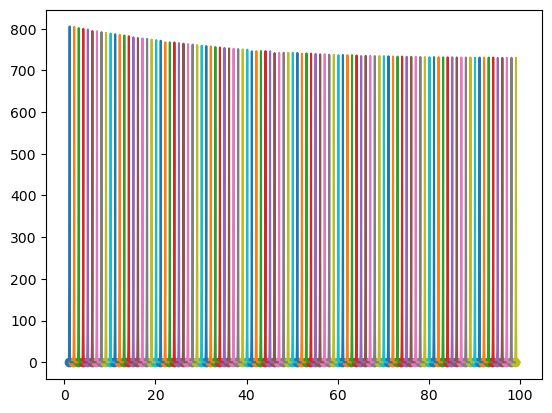

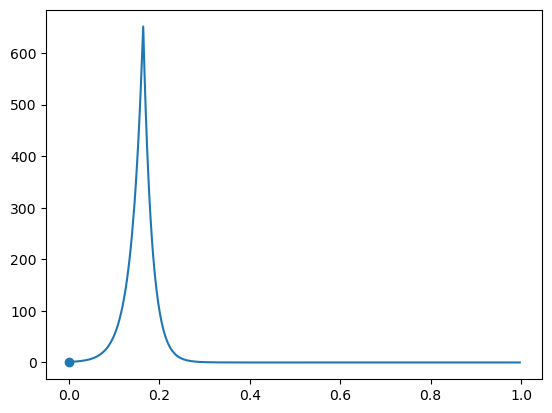

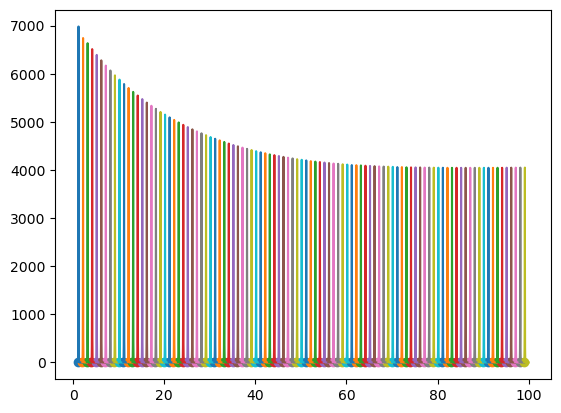

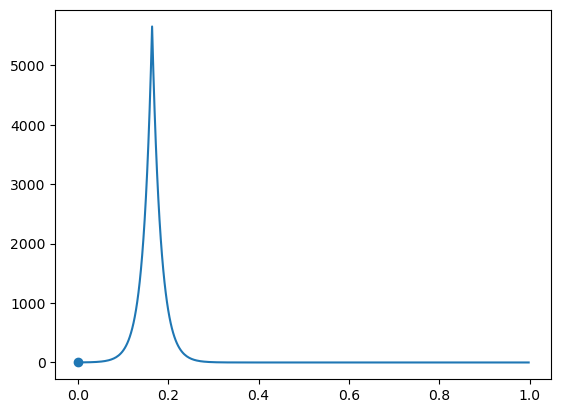

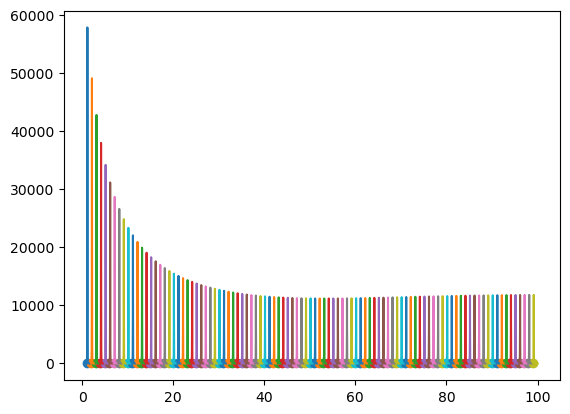

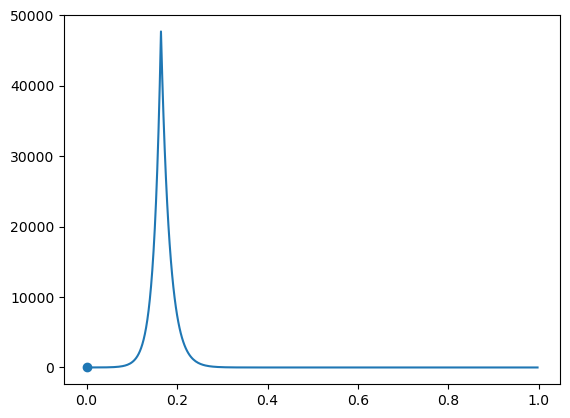

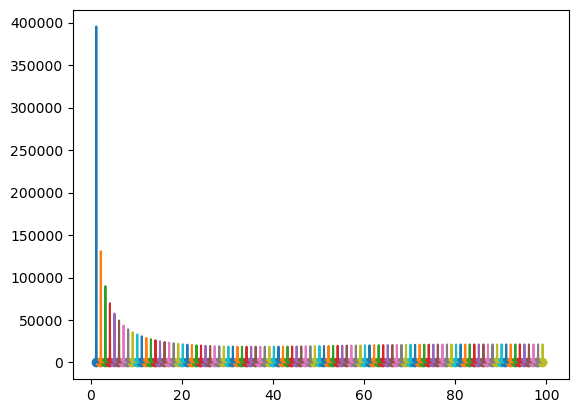

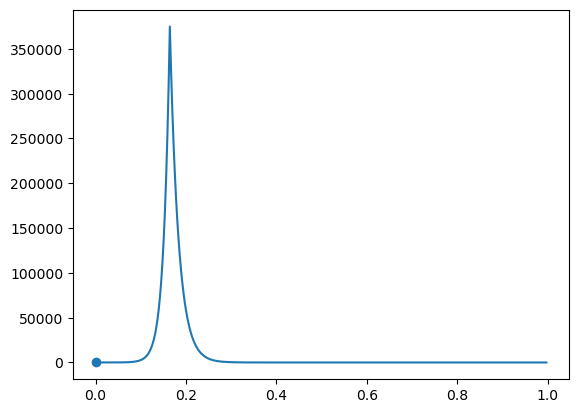

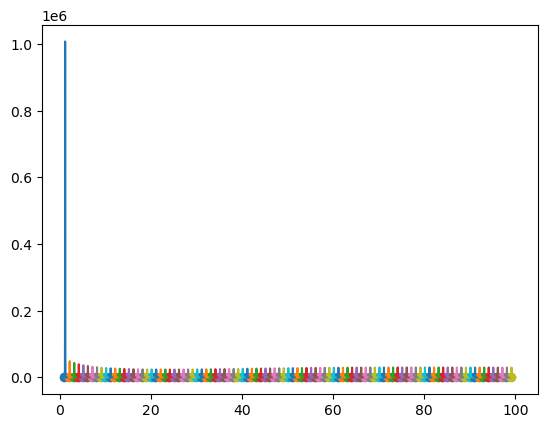

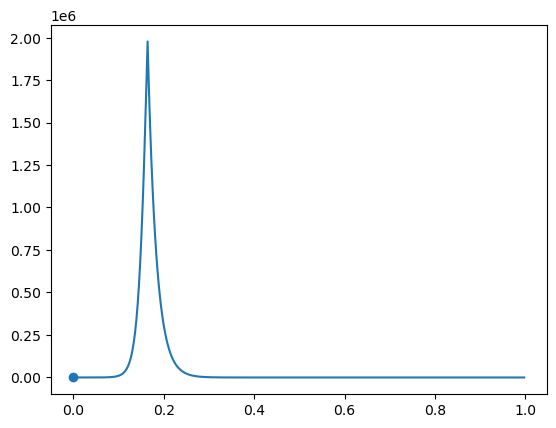

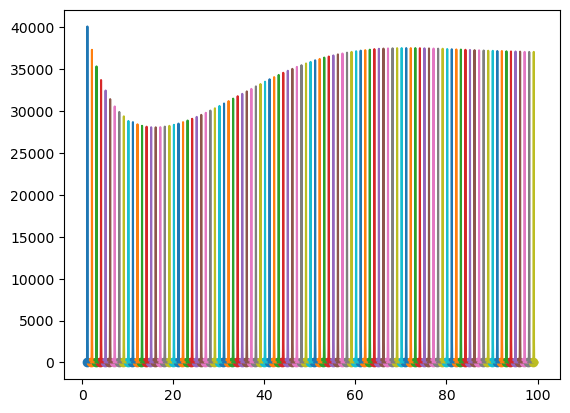

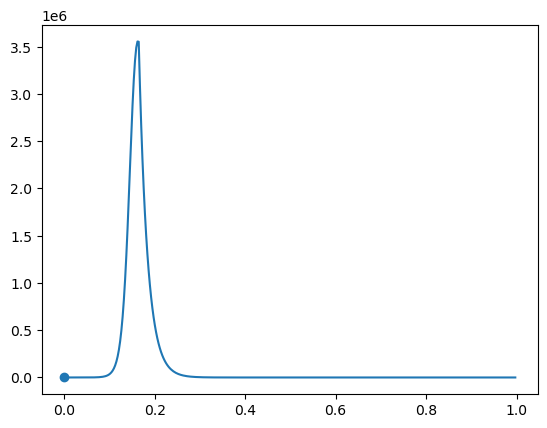

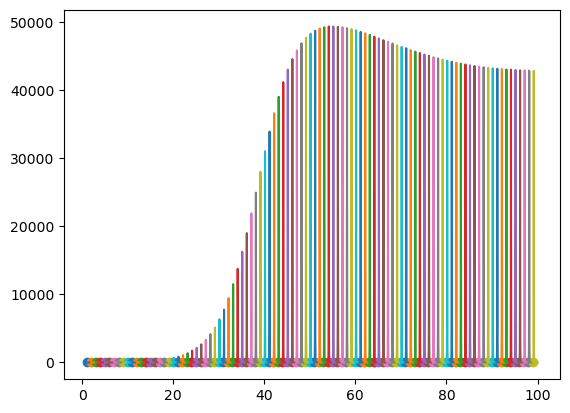

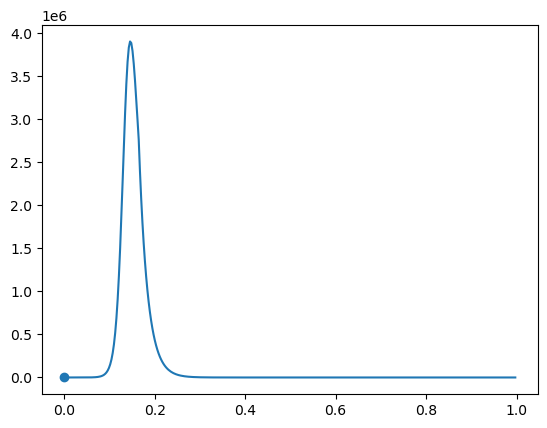

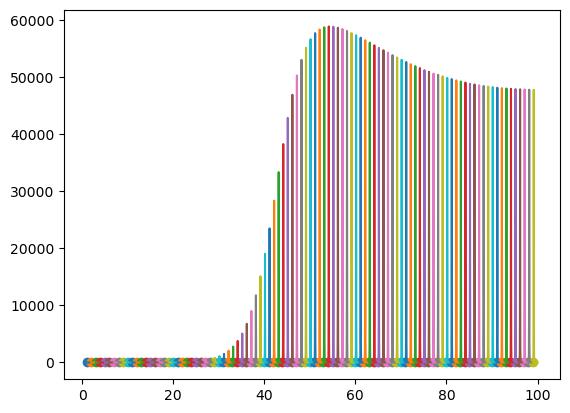

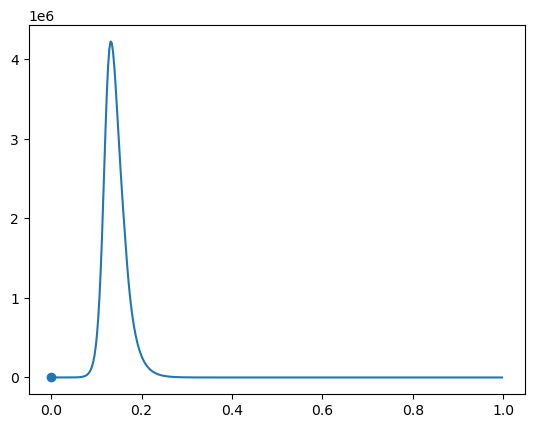

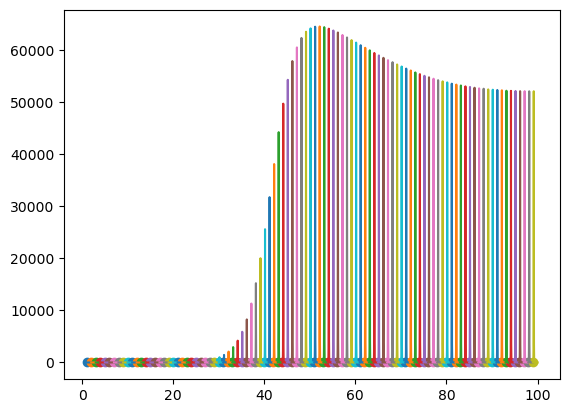

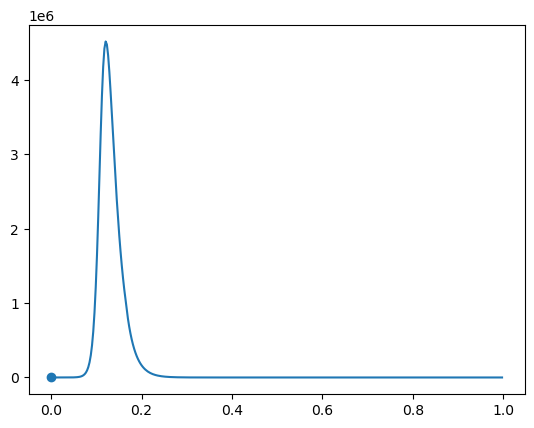

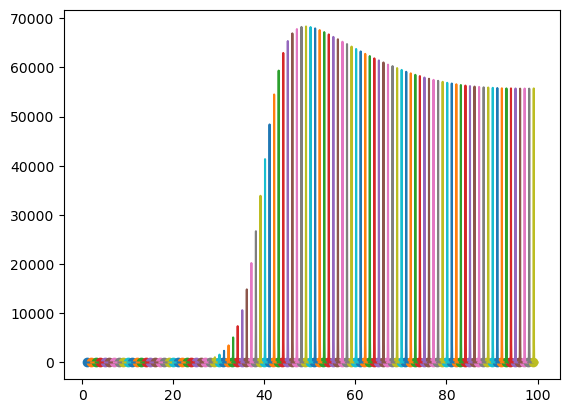

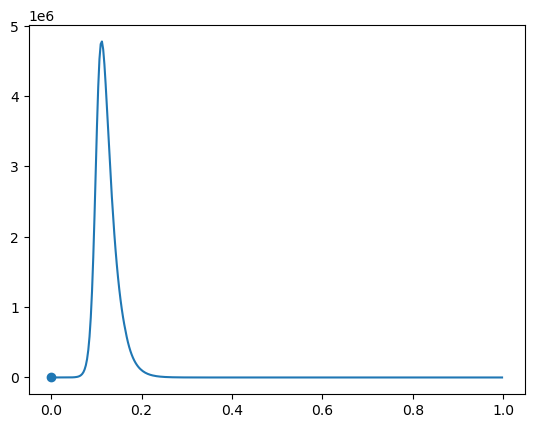

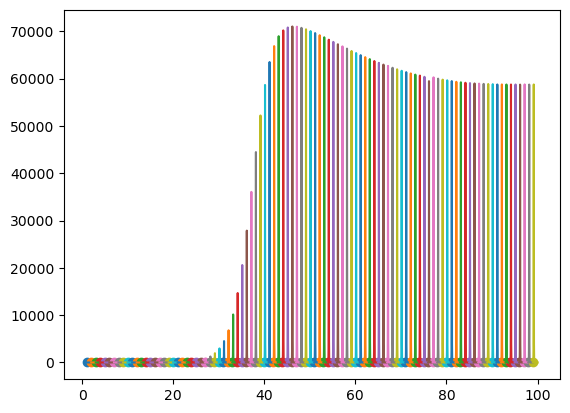

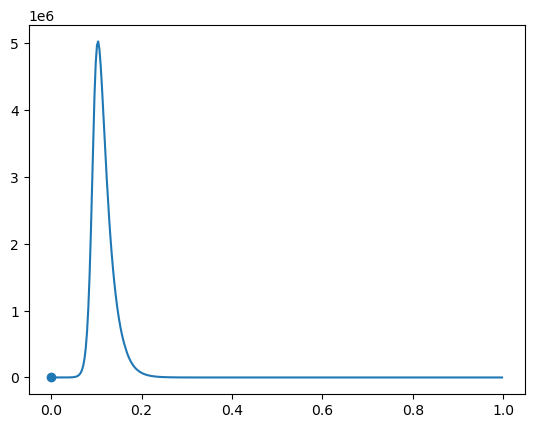

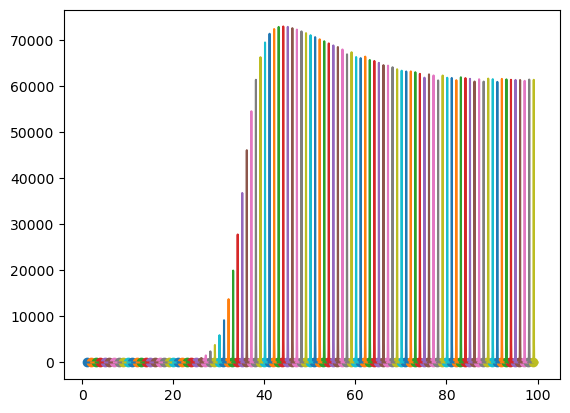

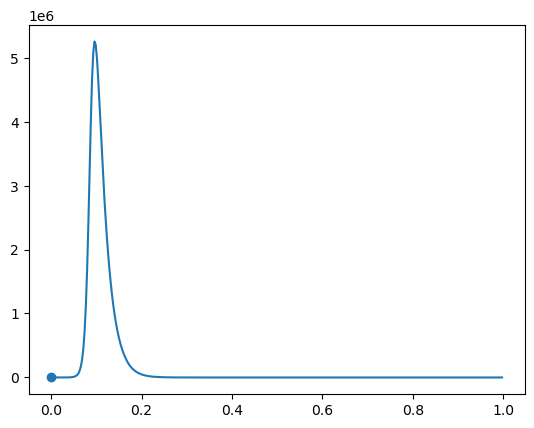

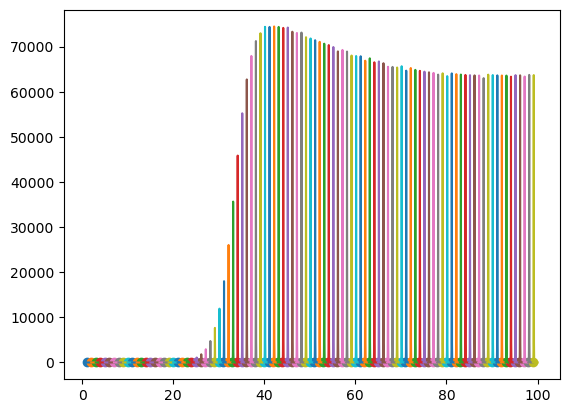

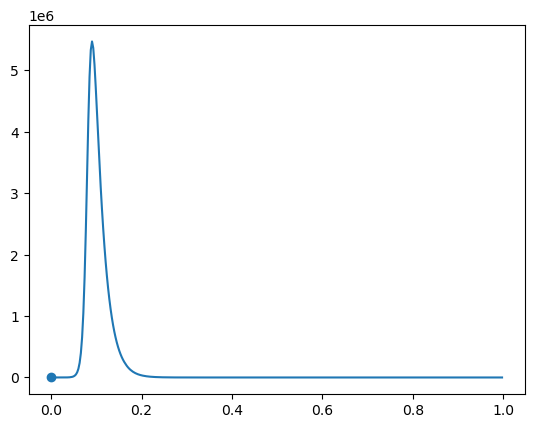

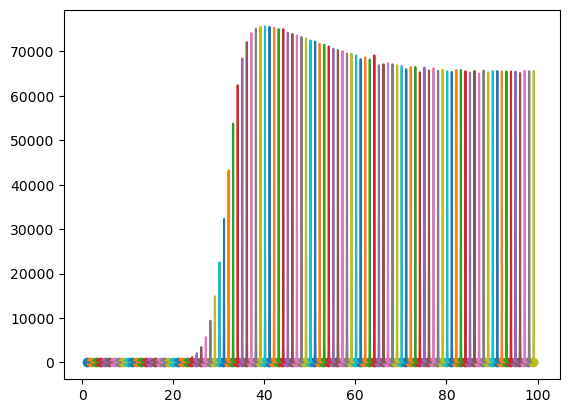

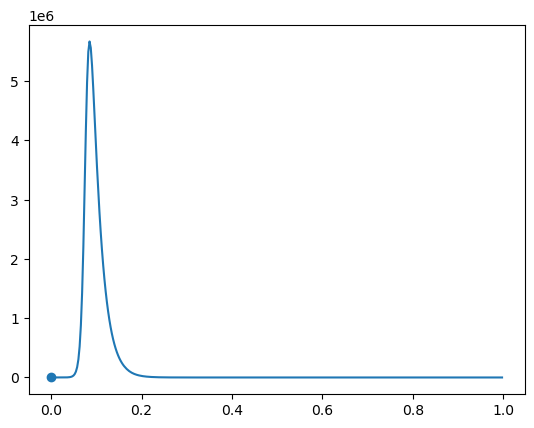

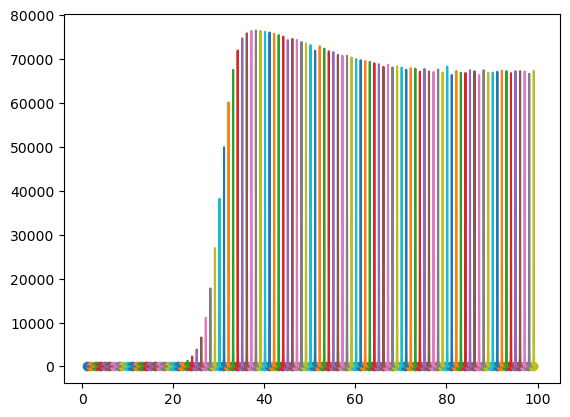

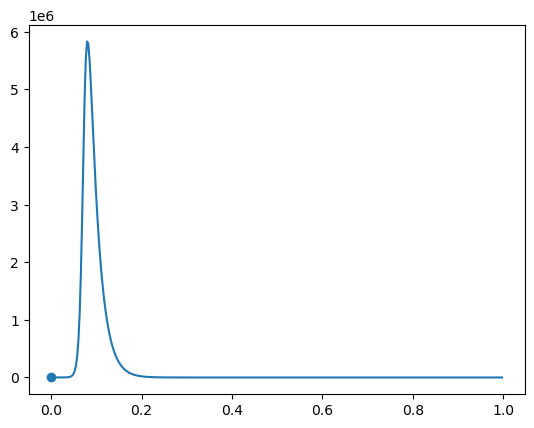

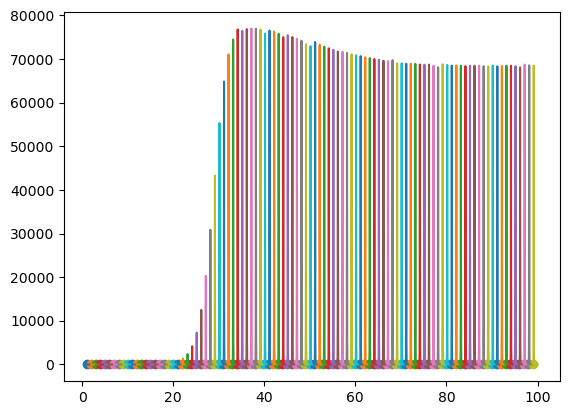

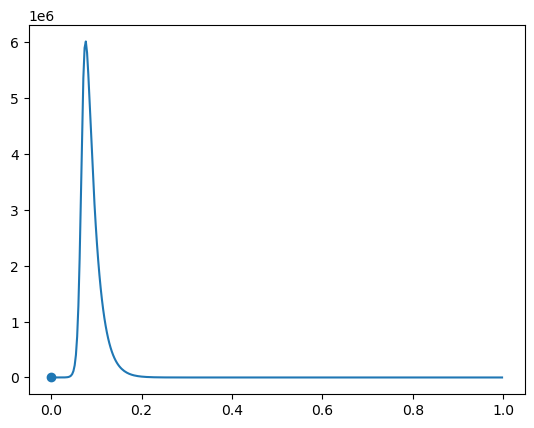

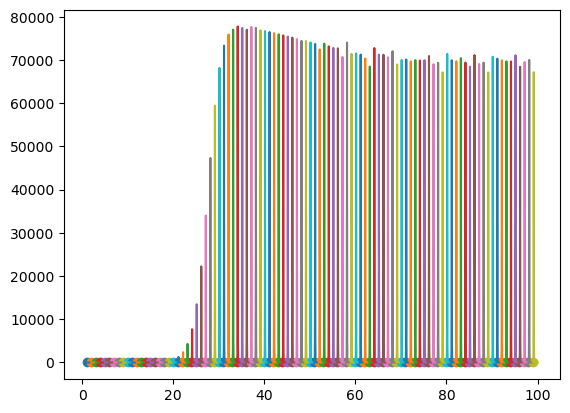

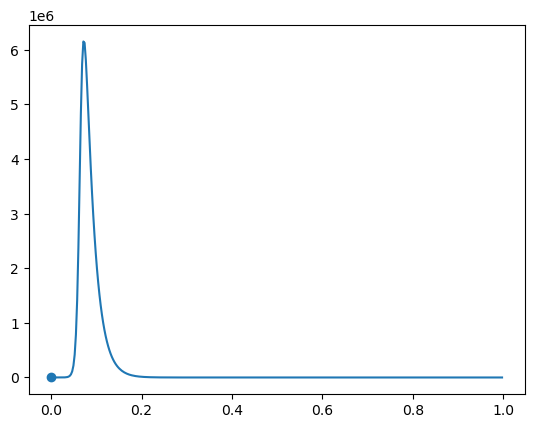

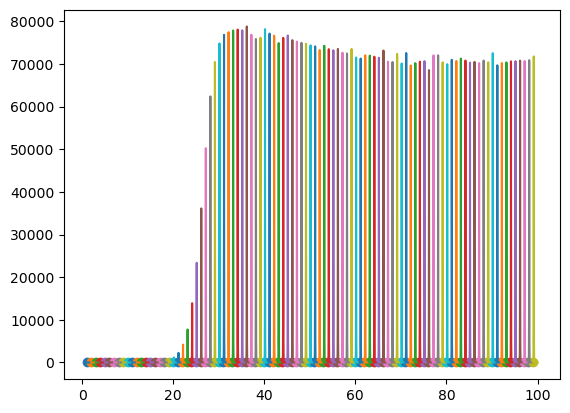

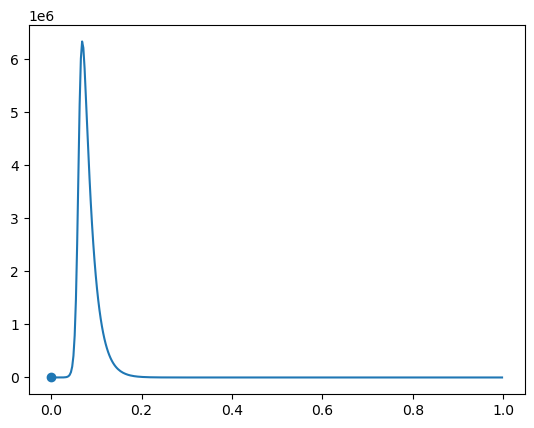

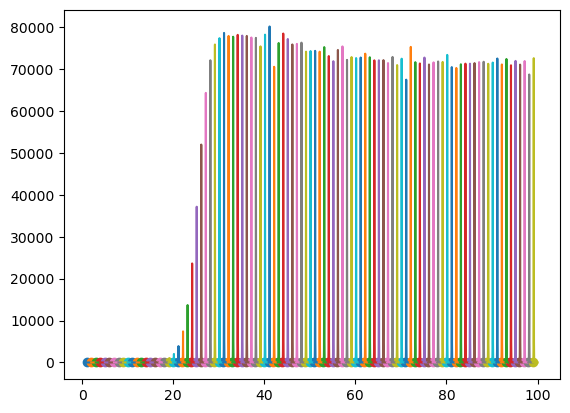

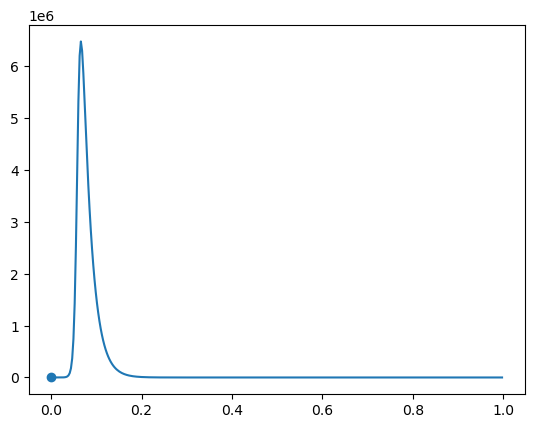

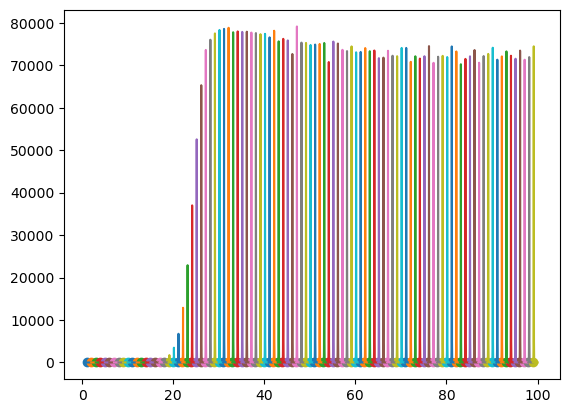

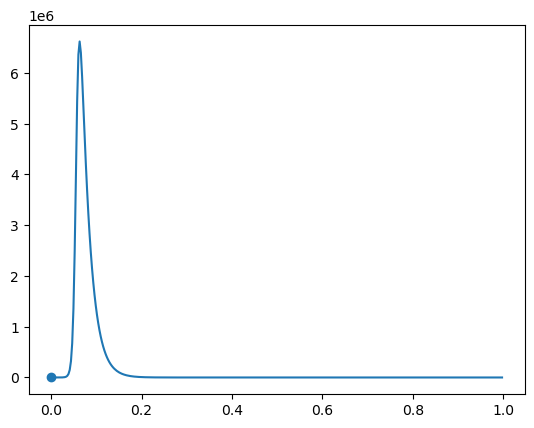

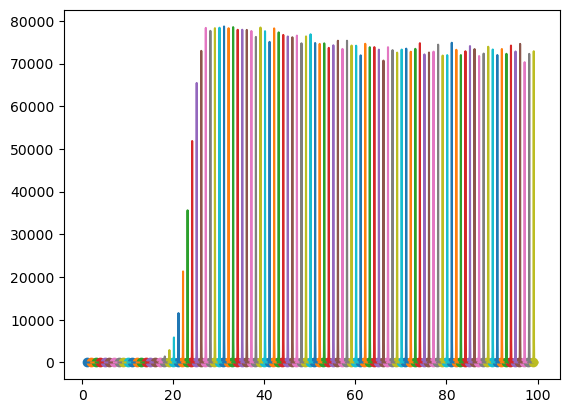

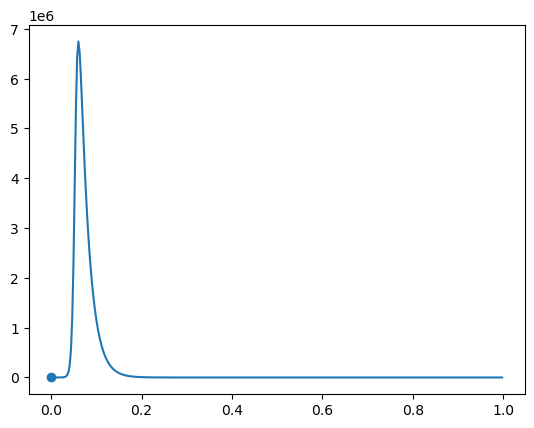

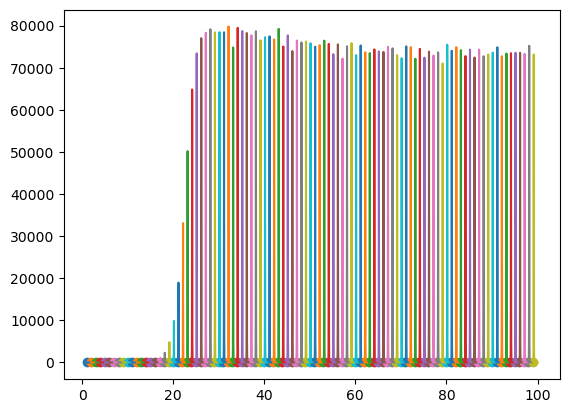

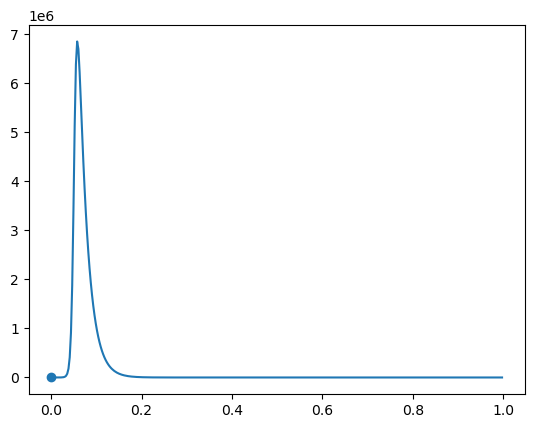

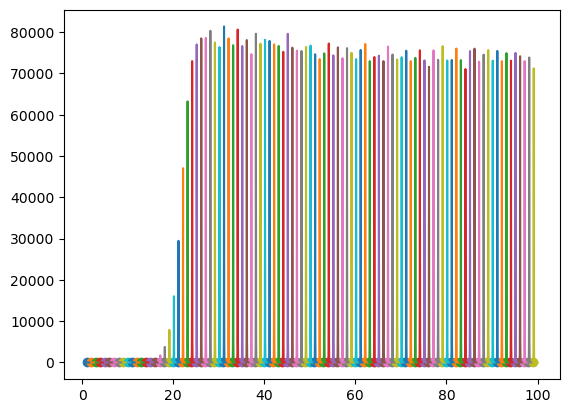

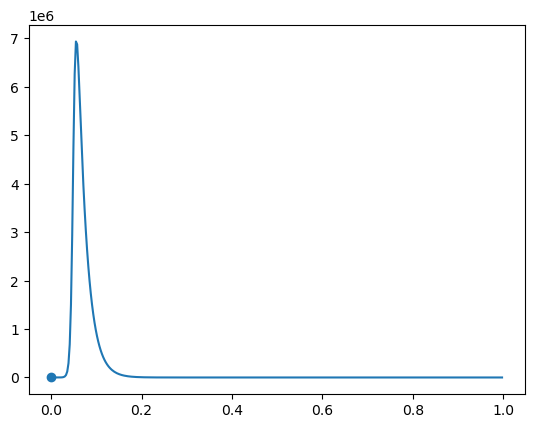

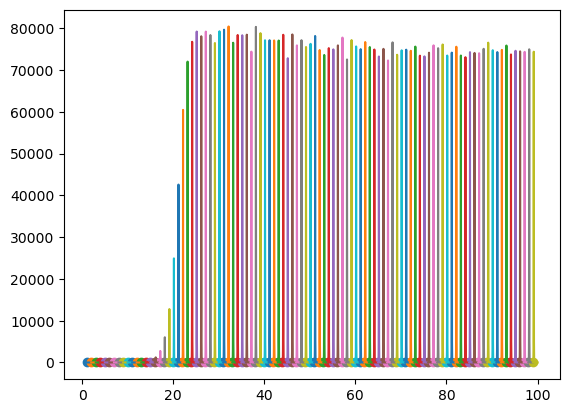

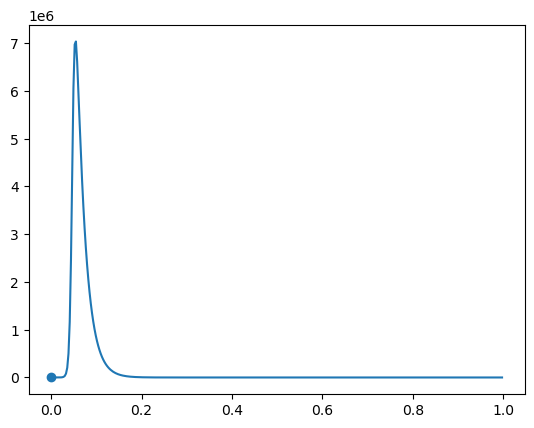

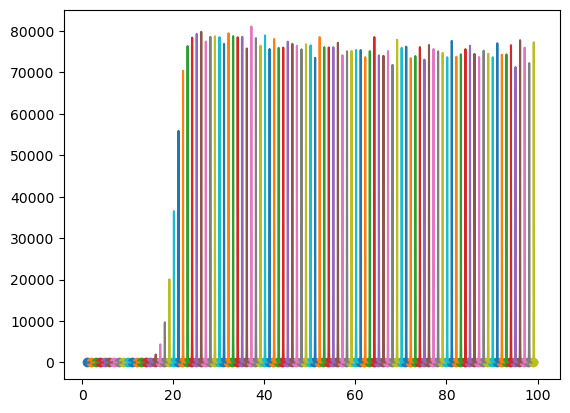

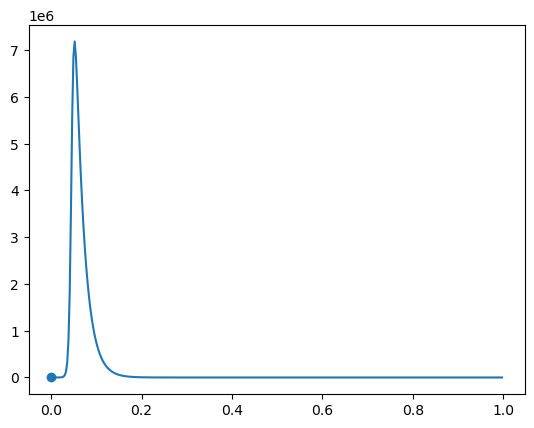

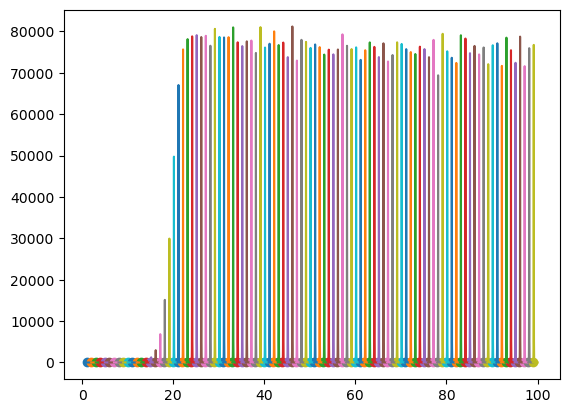

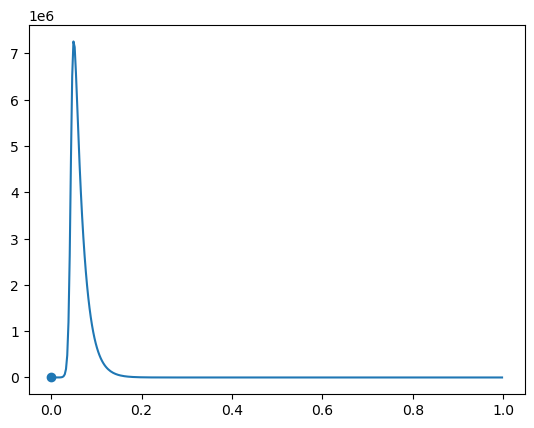

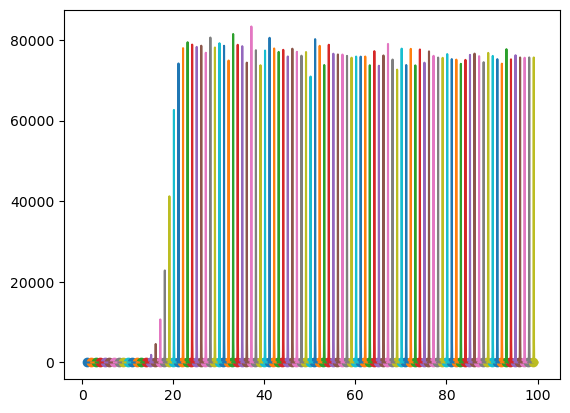

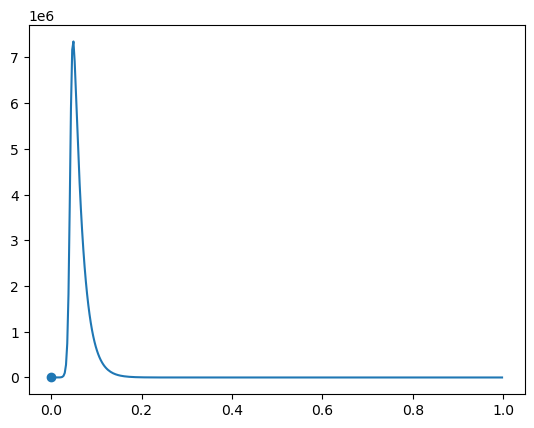

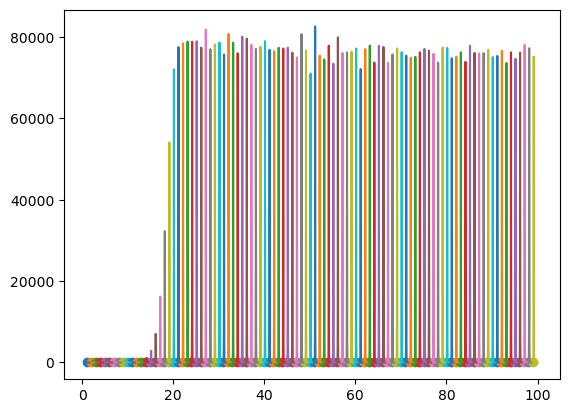

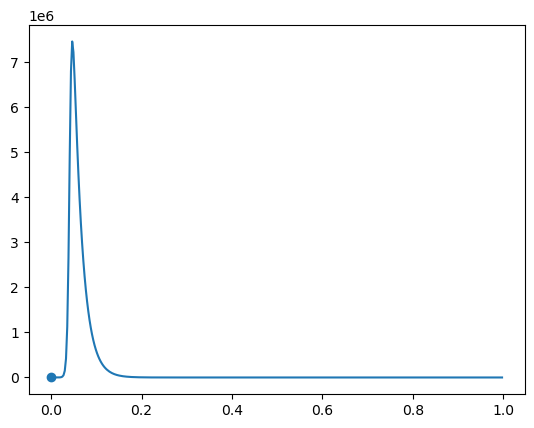

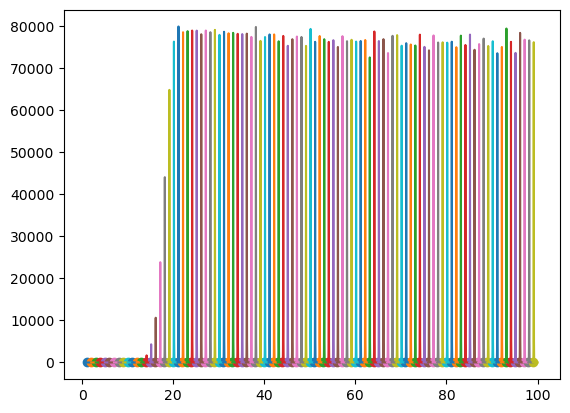

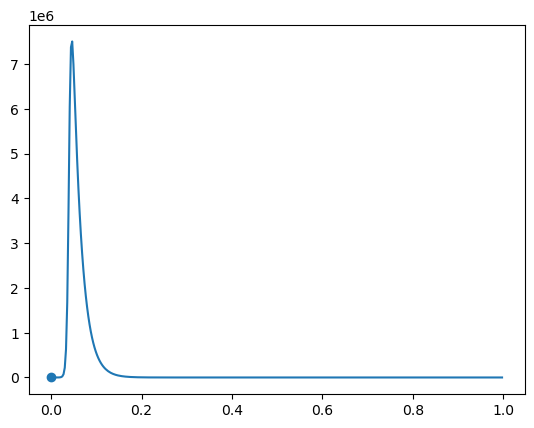

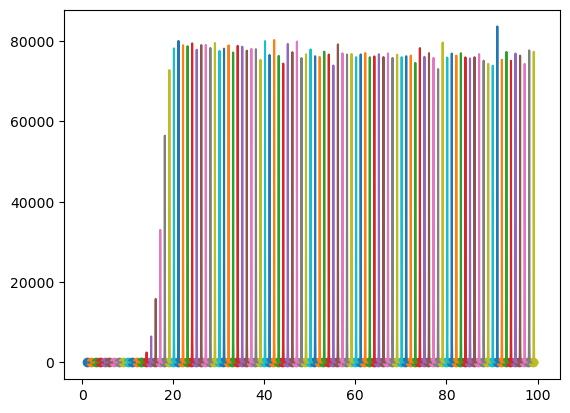

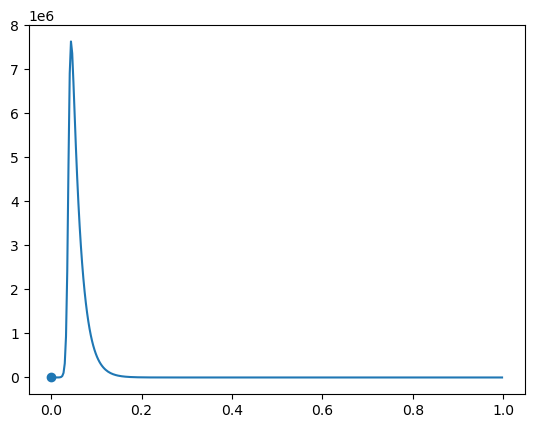

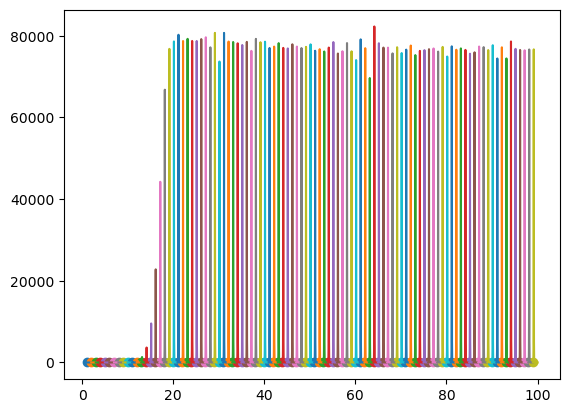

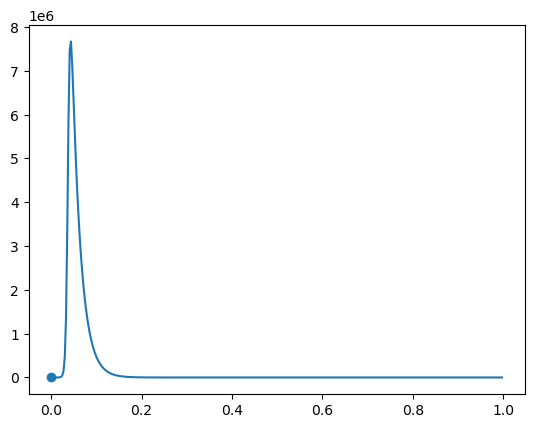

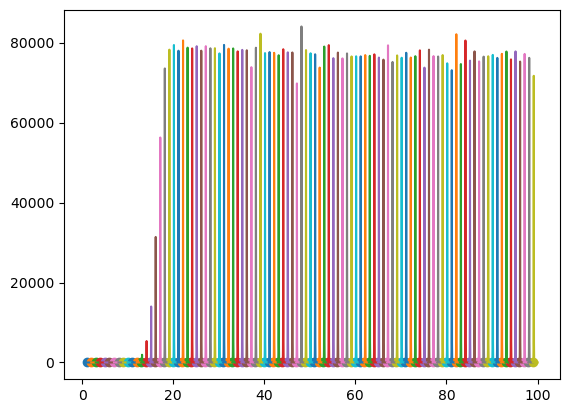

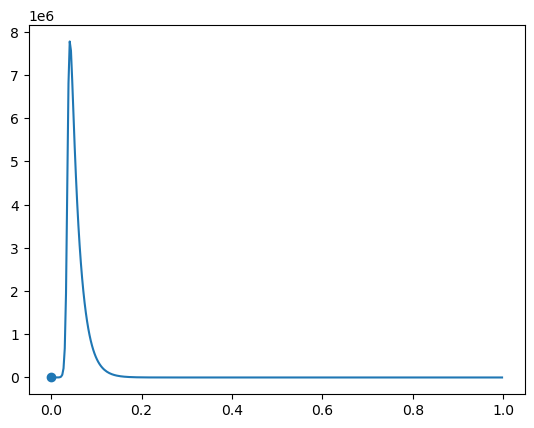

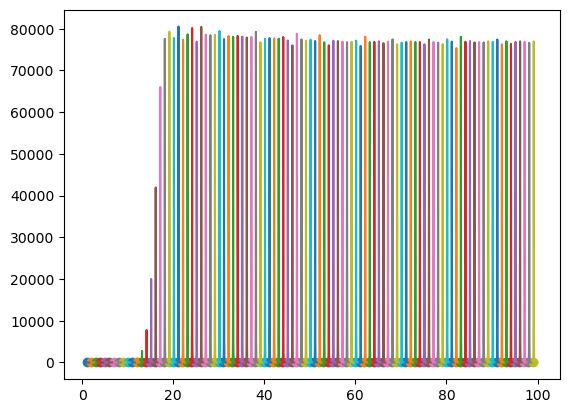

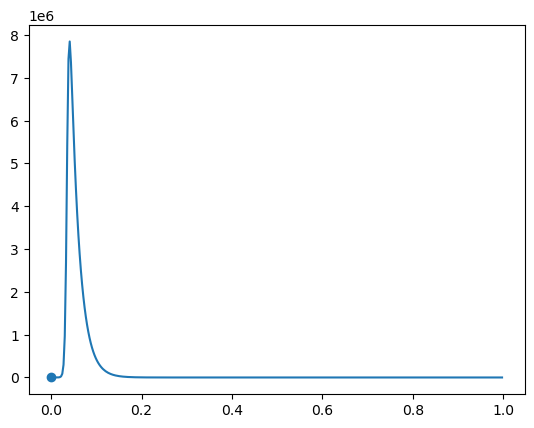

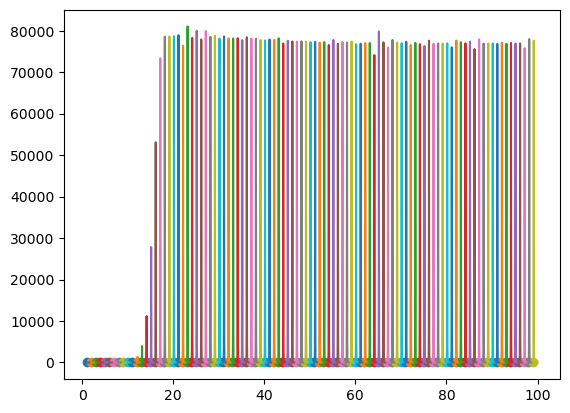

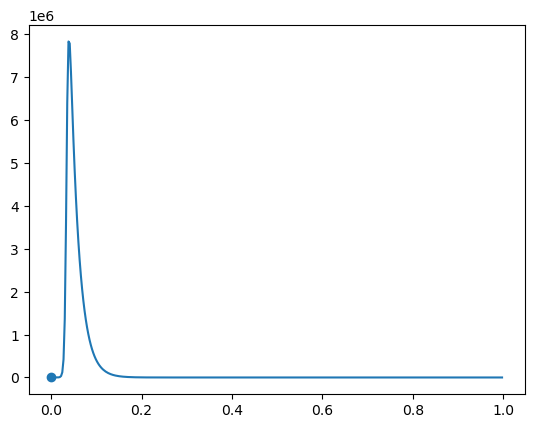

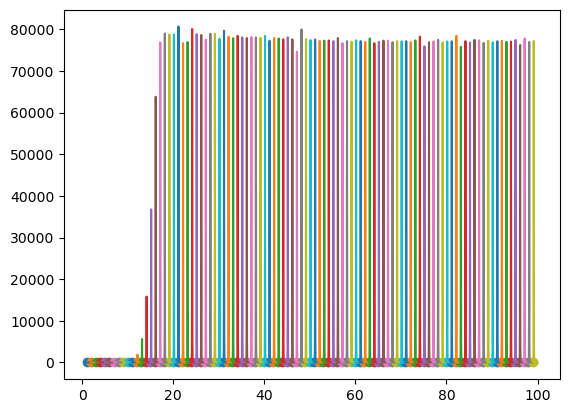

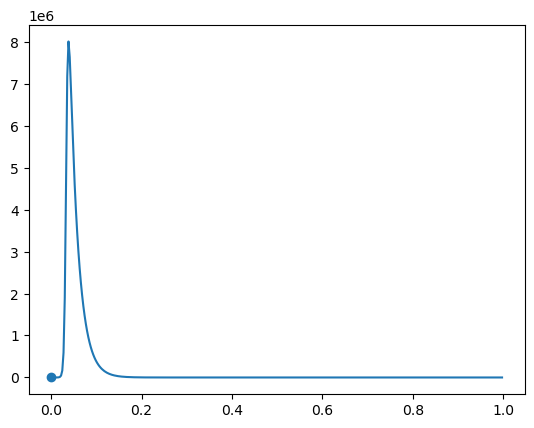

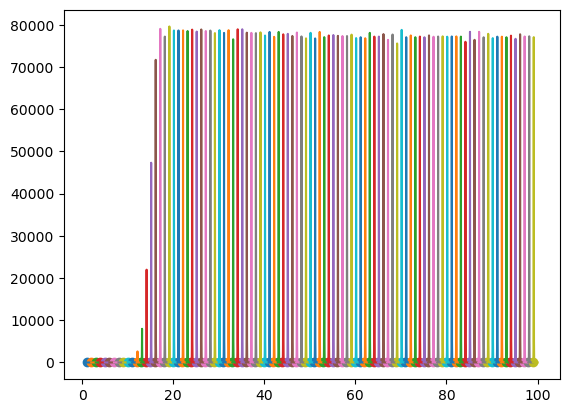

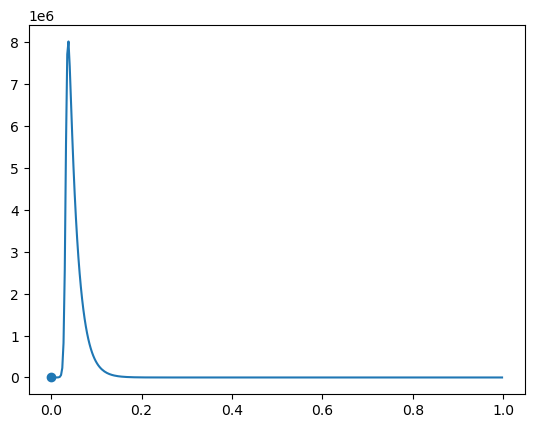

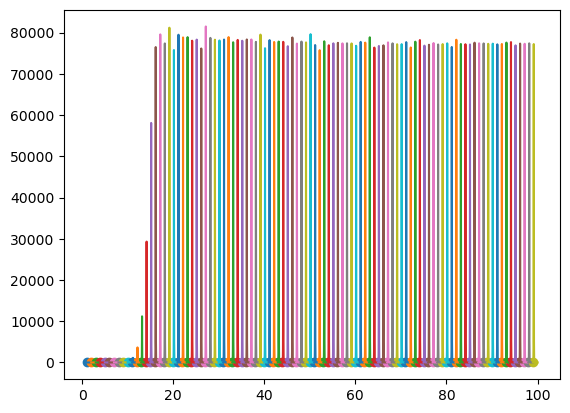

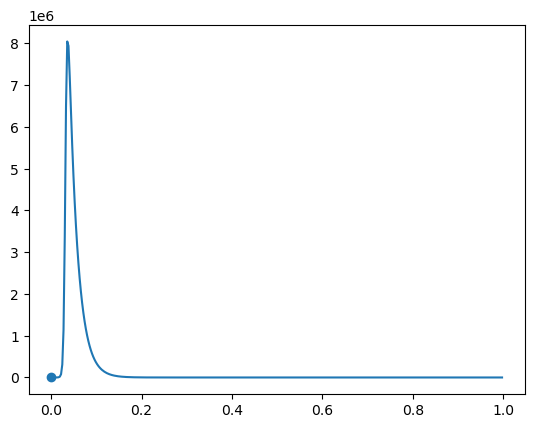

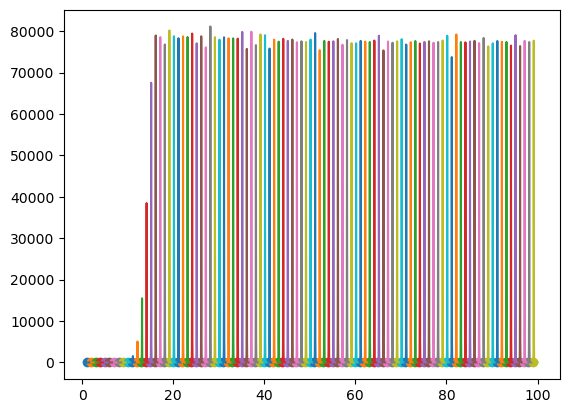

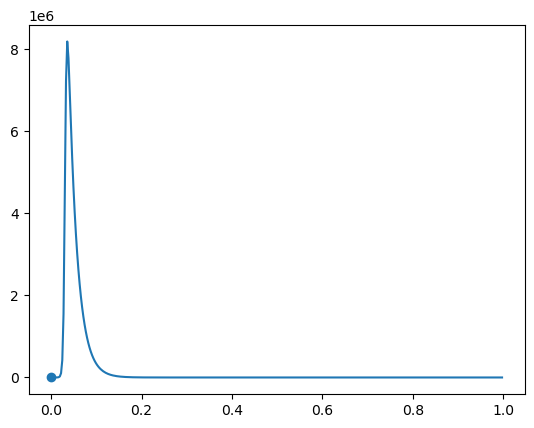

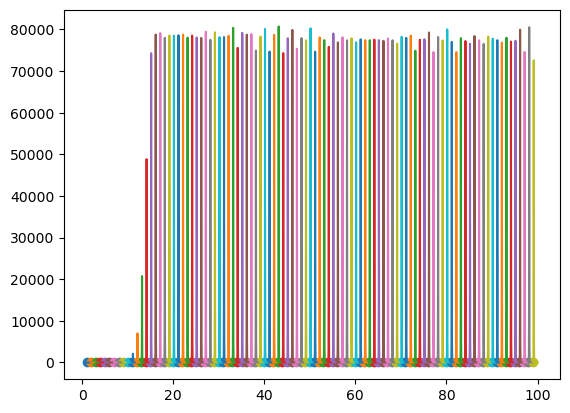

In [56]:
# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 100

# final result list
res_fin = []

for beta_aug in np.arange(1.25,11.25,0.25):
    y0 = define_initial_condition()
    beta_aug = beta_aug*gamma
    res_tmp = []
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        plt.scatter((season*365)/365,y0[N:2*N].sum())
        if(season == 0):
            plt.show()
        if(season >= season-10):
            res_tmp.append(np.max(ret[:,N:2*N].sum(axis=1)*pop))
    #plt.legend()
    plt.show()
    res_fin.append(np.mean(res_tmp))

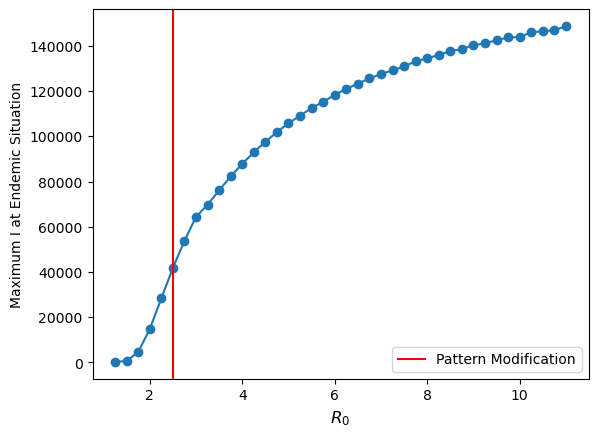

In [60]:
plt.plot(np.arange(1.25,11.25,0.25), res_fin, '-o')
plt.xlabel(r'$R_0$', fontsize = 12)
plt.axvline(np.arange(1.25,11.25,0.25)[5], label = 'Pattern Modification', color = 'red')
plt.ylabel('Maximum I at Endemic Situation')
plt.legend()

## Part 4: Transition in a city from one pattern to another

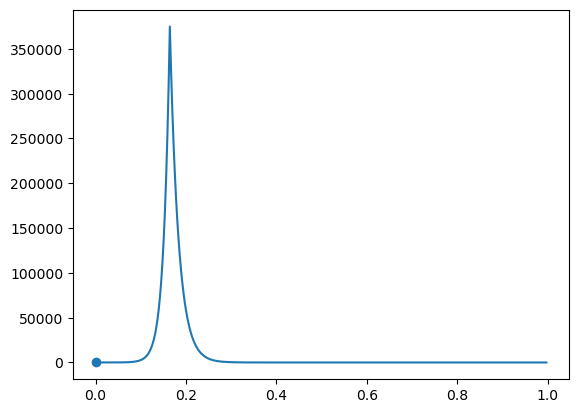

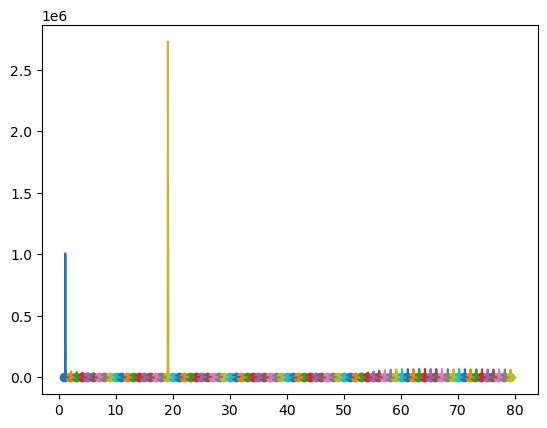

In [139]:
# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 80

beta_aug = 2.5*gamma

y0 = define_initial_condition()
for season in np.arange(seasons):
    if(season >= 19):
        beta_aug = 4.0*gamma
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
    plt.scatter((season*365)/365,y0[N:2*N].sum())
    if(season == 0):
        plt.show()
plt.show()

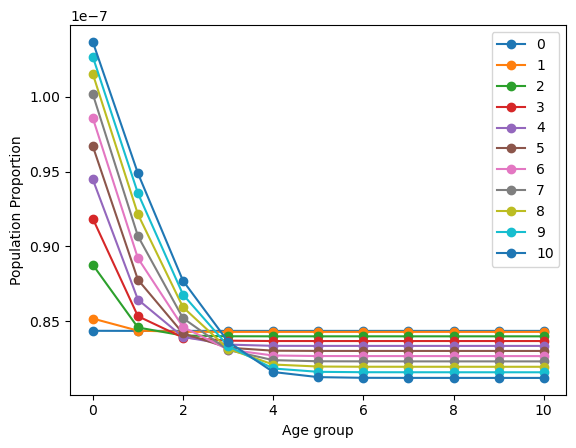

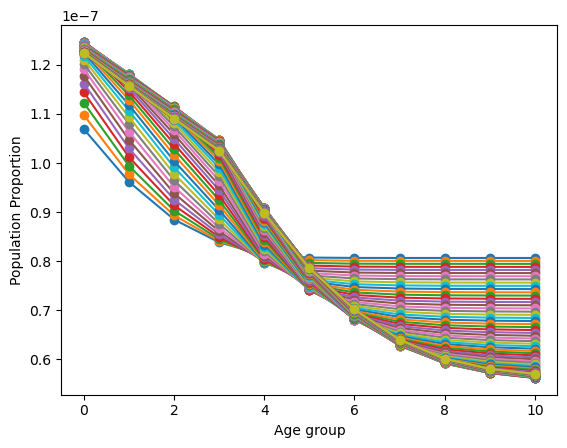

In [147]:
# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 100

beta_aug = 2.5*gamma

y0 = define_initial_condition()
for season in np.arange(seasons):
    if(season >= 10):
        beta_aug = 3.0*gamma
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0)
    inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
    #print((ret[364,10:]*pop - ret[0,10:]*pop).sum())
    prop_pop = alpha*pop*inf_total
    plt.plot((pop/prop_pop)*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 0), '-o', label = season)
    plt.ylabel('Population Proportion')
    plt.xlabel('Age group')
    if(season == 10):
        plt.legend()
        plt.show()
plt.show()

## Part 5: Stochastic pattern

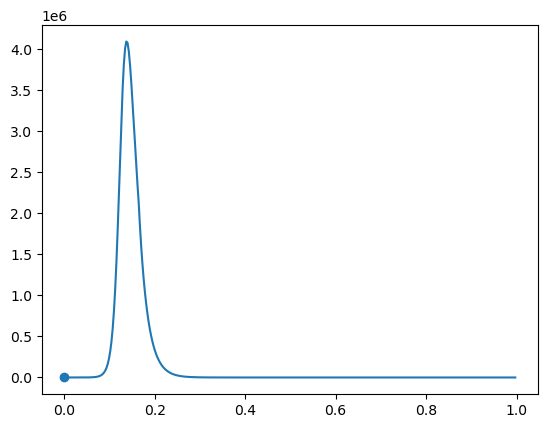

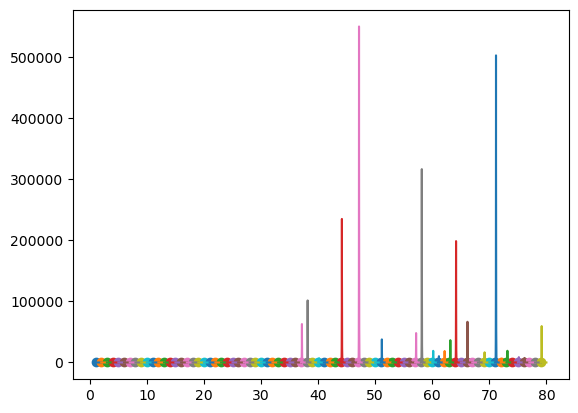

In [151]:
# random seed
np.random.seed(123)

# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 80

y0 = define_initial_condition()
for season in np.arange(seasons):
    beta_aug = np.random.uniform(2,4)*gamma
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
    plt.scatter((season*365)/365,y0[N:2*N].sum())
    if(season == 0):
        plt.show()
plt.show()

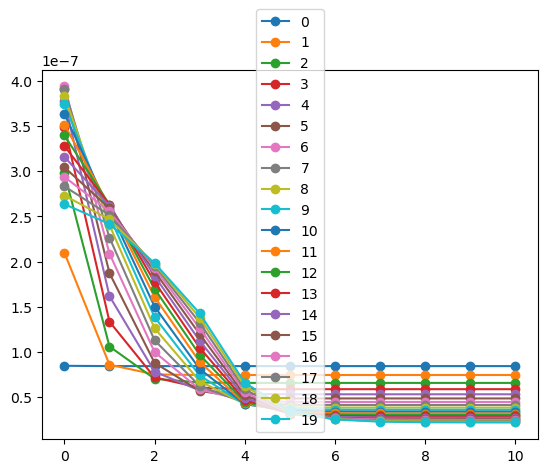

In [154]:
# random seed
np.random.seed(123)

# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma
R0_aug = beta_aug/gamma
R0_0 = beta_0/gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 20

#beta vector
beta_vec = []

y0 = define_initial_condition()
for season in np.arange(seasons):
    beta_aug = np.random.uniform(2,4)*gamma
    beta_vec.append(beta_aug)
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0)
    inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
    #print((ret[364,10:]*pop - ret[0,10:]*pop).sum())
    prop_pop = alpha*pop*inf_total
    plt.plot((pop/prop_pop)*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 0), '-o', label = season)
plt.legend()
plt.show()

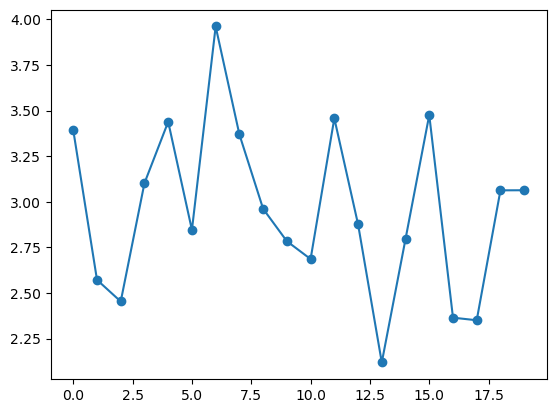

In [158]:
plt.plot(np.array(beta_vec)/gamma,'-o')